In [1]:
import gplugins.tidy3d as gt
import numpy as np
import tidy3d as td
import xarray as xr   # <- nové
import matplotlib.pyplot as plt

nm = 1e-3  # Tidy3D používá µm, takže 1 nm = 1e-3 µm

td.config.logging_level = "CRITICAL"
sin = td.material_library["Si3N4"]["Luke2015Sellmeier"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]



In [40]:
core_thickness = 300 * nm
core_widths = [0.75, 1.0, 1.25, 1.5]  # v µm
gaps = [0.25,0.500, 1]#np.arange(50, 750, 50) * nm    # v µm
ratios = [0.1, 0.25, 0.5]

tol_g = 0.025
tol_w = 0.025



In [12]:
Nw = len(core_widths)
Ng = len(gaps)
Nr = len(ratios)

# 3D pole: [core_width, gap, ratio]
coupling_length = np.empty((Nw, Ng, Nr))

for iw, w in enumerate(core_widths):
    for ig, gap in enumerate(gaps):
        coupler_test = gt.modes.WaveguideCoupler(
            wavelength=1.55,                  # µm
            core_width=(w, w),
            gap=gap,
            core_thickness=core_thickness,
            slab_thickness=0.0,
            core_material=sin,
            clad_material=sio2,
            clad_thickness=8,
            box_material=sio2,
            box_thickness=8,
            group_index_step=True,
            grid_resolution=10,
        )

        for ir, ratio in enumerate(ratios):
            # coupling_length pravděpodobně vrací délku v µm
            Lc = coupler_test.coupling_length(ratio)
            coupling_length[iw, ig, ir] = Lc[0]

2025-11-27 13:15:21.683 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from /home/sadilek/.gdsfactory/modes/WaveguideCoupler_502c14cfe4cbc873.npz.
2025-11-27 13:15:21.687 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from /home/sadilek/.gdsfactory/modes/WaveguideCoupler_a4cb38239abab707.npz.
2025-11-27 13:15:24.886 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into /home/sadilek/.gdsfactory/modes/WaveguideCoupler_9f400adcb7b34ef6.npz.
2025-11-27 13:15:24.894 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from /home/sadilek/.gdsfactory/modes/WaveguideCoupler_13f17f3c69ed5105.npz.
2025-11-27 13:15:24.897 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from /home/sadilek/.gdsfactory/modes/WaveguideCoupler_c8e0e9ab7cfe5832.npz.
2025-11-27 13:15:27.887 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into /home/sadilek/.gdsfactory/modes/WaveguideCoupler_6759d3e778440cd1.npz.
2025-11-27 13:15:27.897 | INFO     | gplugins.tidy3d.mod

In [13]:
print(type(Lc), Lc, getattr(Lc, "shape", None))

<class 'numpy.ndarray'> [436.20301772] (1,)


In [14]:
ds = xr.Dataset(
    data_vars=dict(
        coupling_length=(("core_width", "gap", "ratio"), coupling_length),
    ),
    coords=dict(
        core_width=("core_width", core_widths),     # µm
        gap=("gap", gaps),                         # µm
        ratio=("ratio", ratios),
    ),
)


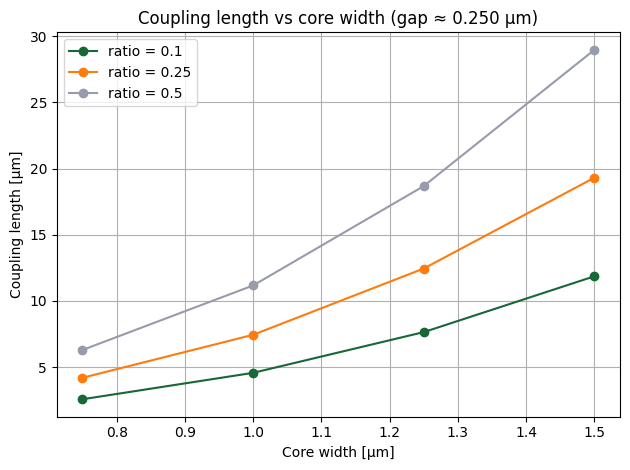

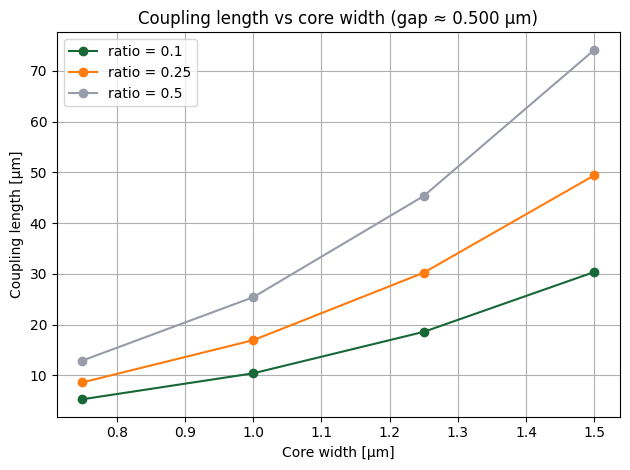

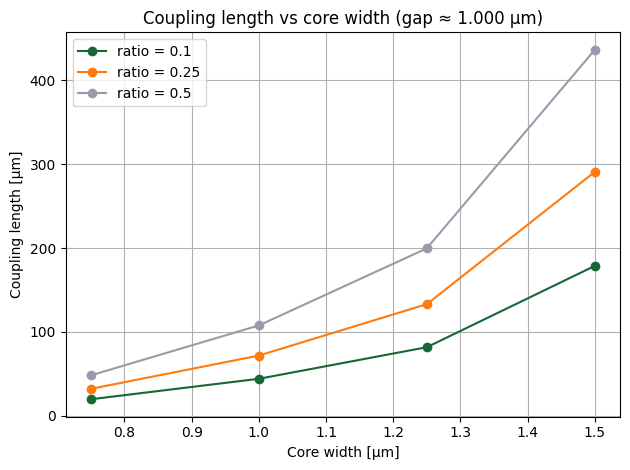

In [28]:
for gp in gaps:

    gap_fixed = gp  # 150 nm v µm (jestli máš gaps v µm)

    da = ds.coupling_length.sel(gap=gap_fixed, method="nearest")

    plt.figure()
    for r in ds.coords["ratio"].values:
        plt.plot(
            ds.coords["core_width"].values,
            ds.coupling_length.sel(gap=gap_fixed, ratio=r, method="nearest"),
            marker="o",
            label=f"ratio = {r}",
        )

    plt.xlabel("Core width [µm]")
    plt.ylabel("Coupling length [µm]")
    plt.title(f"Coupling length vs core width (gap ≈ {gap_fixed:.3f} µm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
df = ds.to_dataframe().reset_index()
df.to_csv("directional_coupler_lengths.csv", index=False)

In [20]:
Lc_curve = ds.coupling_length.sel(core_width=0.75, gap=0.5, method="nearest")

print(Lc_curve)

<xarray.DataArray 'coupling_length' (ratio: 3)> Size: 24B
array([ 5.29630568,  8.61891031, 12.92836547])
Coordinates:
    core_width  float64 8B 0.75
    gap         float64 8B 0.5
  * ratio       (ratio) float64 24B 0.1 0.25 0.5


In [21]:
print(ds)

<xarray.Dataset> Size: 368B
Dimensions:          (core_width: 4, gap: 3, ratio: 3)
Coordinates:
  * core_width       (core_width) float64 32B 0.75 1.0 1.25 1.5
  * gap              (gap) float64 24B 0.25 0.5 1.0
  * ratio            (ratio) float64 24B 0.1 0.25 0.5
Data variables:
    coupling_length  (core_width, gap, ratio) float64 288B 2.582 4.203 ... 436.2


In [22]:
import numpy as np
import xarray as xr
import pandas as pd

def monte_carlo_coupler(
    ds: xr.Dataset,
    core_width_nom: float,
    gap_nom: float,
    ratio: float,
    sigma_w: float,
    sigma_g: float,
    n_samples: int = 1000,
    clip_to_grid: bool = True,
    seed: int | None = None,
):
    """
    Monte Carlo analýza coupling length pro odchylky šířky a mezery.

    Parametry
    ---------
    ds : xr.Dataset
        Dataset s coupler LUT (proměnná 'coupling_length').
    core_width_nom : float
        Nominální šířka jádra [µm].
    gap_nom : float
        Nominální mezera [µm].
    ratio : float
        Target coupling ratio (musí být osa v ds.coords["ratio"]).
    sigma_w : float
        Směrodatná odchylka šířky [µm], např. 0.01 = 10 nm.
    sigma_g : float
        Směrodatná odchylka mezery [µm].
    n_samples : int
        Počet Monte Carlo vzorků.
    clip_to_grid : bool
        Pokud True, hodnoty mimo rozsah LUT se oříznou na min/max z gridu.
    seed : int | None
        Seed RNG pro reprodukovatelnost.

    Návrat
    ------
    result : dict
        {
          "df": DataFrame se sloupci [core_width, gap, coupling_length],
          "L_mean": průměrná délka,
          "L_std": směrodatná odchylka,
          "L_p5": 5. percentil,
          "L_p95": 95. percentil,
        }
    """
    rng = np.random.default_rng(seed)

    # 1) Návhodné vzorky w, g
    w_samples = core_width_nom + rng.normal(0.0, sigma_w, size=n_samples)
    g_samples = gap_nom + rng.normal(0.0, sigma_g, size=n_samples)

    # 2) případné ořezání na rozsah gridu, aby interp neextrapoloval
    w_min = float(ds.coords["core_width"].min())
    w_max = float(ds.coords["core_width"].max())
    g_min = float(ds.coords["gap"].min())
    g_max = float(ds.coords["gap"].max())

    if clip_to_grid:
        w_samples = np.clip(w_samples, w_min, w_max)
        g_samples = np.clip(g_samples, g_min, g_max)

    # 3) vypočet L pro každý vzorek
    L_samples = np.empty(n_samples, dtype=float)

    for i in range(n_samples):
        L = ds.coupling_length.interp(
            core_width=w_samples[i],
            gap=g_samples[i],
            ratio=ratio,
        )
        L_samples[i] = float(np.asarray(L).squeeze())

    # 4) statistika
    L_mean = float(L_samples.mean())
    L_std = float(L_samples.std())
    L_p5 = float(np.percentile(L_samples, 5))
    L_p95 = float(np.percentile(L_samples, 95))

    df = pd.DataFrame(
        dict(
            core_width=w_samples,
            gap=g_samples,
            coupling_length=L_samples,
        )
    )

    return dict(
        df=df,
        L_mean=L_mean,
        L_std=L_std,
        L_p5=L_p5,
        L_p95=L_p95,
    )


In [23]:
result = monte_carlo_coupler(
    ds=ds,
    core_width_nom=1,
    gap_nom=0.25,
    ratio=0.5,
    sigma_w=0.025,   # 10 nm
    sigma_g=0.025,  # 15 nm
    n_samples=2000,
    seed=42,
)

print("L_mean   =", result["L_mean"])
print("L_std    =", result["L_std"])
print("L_p5     =", result["L_p5"])
print("L_p95    =", result["L_p95"])

df = result["df"]


L_mean   = 11.825676824443374
L_std    = 1.0746606008014972
L_p5     = 10.482522676858421
L_p95    = 13.934155832018265


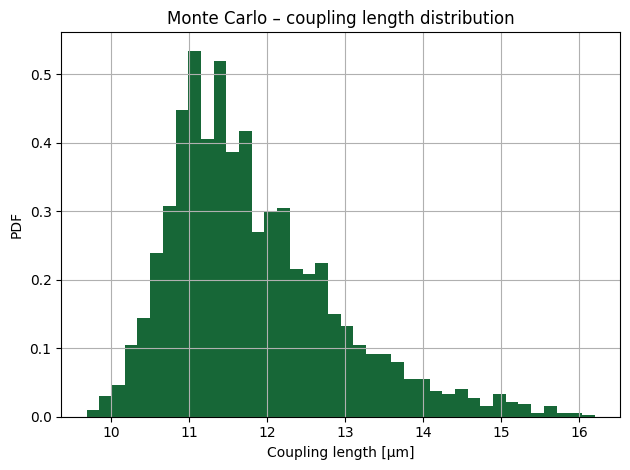

In [24]:
plt.figure()
plt.hist(df["coupling_length"], bins=40, density=True)
plt.xlabel("Coupling length [µm]")
plt.ylabel("PDF")
plt.title("Monte Carlo – coupling length distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

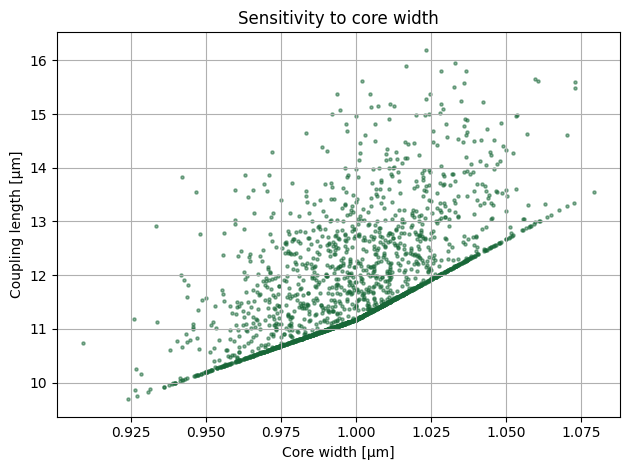

In [25]:
plt.figure()
plt.scatter(df["core_width"], df["coupling_length"], s=5, alpha=0.5)
plt.xlabel("Core width [µm]")
plt.ylabel("Coupling length [µm]")
plt.title("Sensitivity to core width")
plt.grid(True)
plt.tight_layout()
plt.show()

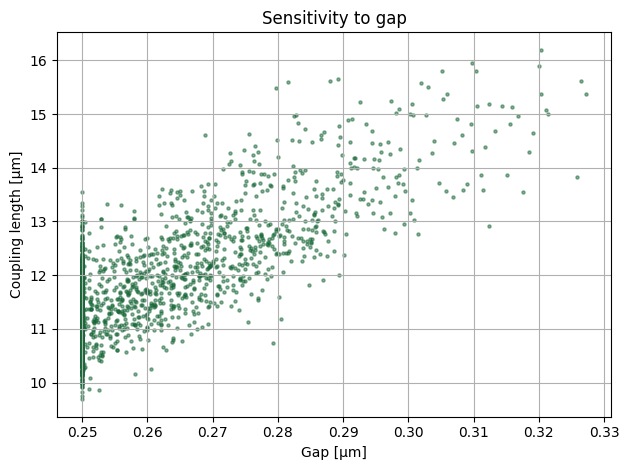

In [26]:
plt.figure()
plt.scatter(df["gap"], df["coupling_length"], s=5, alpha=0.5)
plt.xlabel("Gap [µm]")
plt.ylabel("Coupling length [µm]")
plt.title("Sensitivity to gap")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
print(result["L_mean"], result["L_std"])
print("sigma/mean =", result["L_std"]/result["L_mean"])

11.825676824443374 1.0746606008014972
sigma/mean = 0.09087518767468776


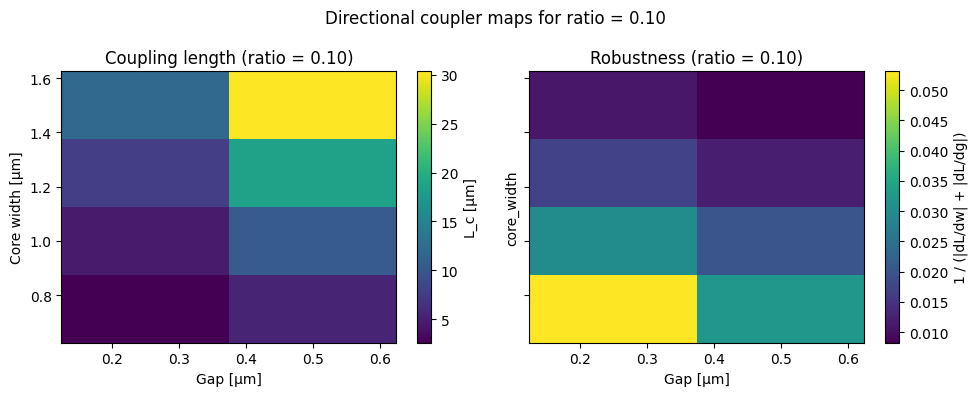

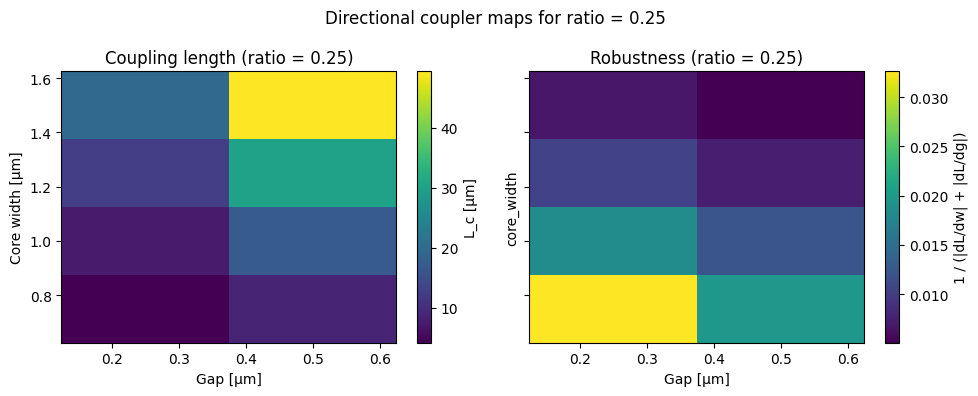

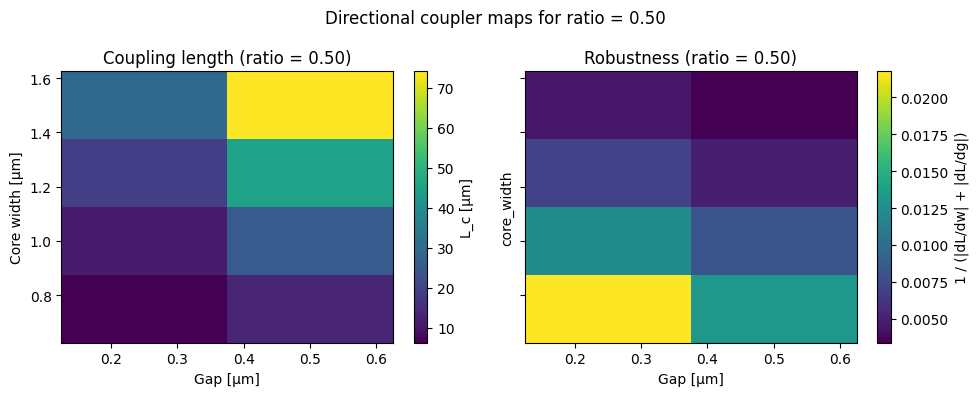

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# parametry, které chceš mapovat
core_widths_sel = [0.75, 1.0, 1.25, 1.5]   # µm
gaps_sel = [0.25, 0.50]                    # µm
ratios_sel = [0.10, 0.25, 0.50]            # 10:90, 25:75, 50:50

# vyber z datasetu jen tyto hodnoty (nejbližší z gridu)
ds_sub = ds.sel(
    core_width=core_widths_sel,
    gap=gaps_sel,
    ratio=ratios_sel,
    method="nearest",
)

# spočítáme derivace na zúženém gridu
# (pozor: na hranách je to jednosměrná derivace, ale pro představu to stačí)
dL_dw = ds_sub.coupling_length.differentiate("core_width")
dL_dg = ds_sub.coupling_length.differentiate("gap")

# jednoduchá metrika citlivosti: součet absolutních hodnot derivací
sensitivity = np.abs(dL_dw) + np.abs(dL_dg)

# aby to nespadlo na 0 (pro případ super rovného místa)
robustness = 1.0 / (sensitivity + 1e-9)

# -------------------------------------------------
# KRESLENÍ MAP: coupling length a "robustness"
# -------------------------------------------------
for r in ratios_sel:
    L_map = ds_sub.coupling_length.sel(ratio=r)   # [core_width, gap]
    R_map = robustness.sel(ratio=r)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # 1) Coupling length
    L_map.plot(
        x="gap",
        y="core_width",
        ax=axes[0],
        cmap="viridis",
        cbar_kwargs={"label": "L_c [µm]"},
    )
    axes[0].set_title(f"Coupling length (ratio = {r:.2f})")
    axes[0].set_xlabel("Gap [µm]")
    axes[0].set_ylabel("Core width [µm]")

    # 2) Robustness
    R_map.plot(
        x="gap",
        y="core_width",
        ax=axes[1],
        cmap="viridis",
        cbar_kwargs={"label": "1 / (|dL/dw| + |dL/dg|)"},
    )
    axes[1].set_title(f"Robustness (ratio = {r:.2f})")
    axes[1].set_xlabel("Gap [µm]")

    fig.suptitle(f"Directional coupler maps for ratio = {r:.2f}")
    plt.tight_layout()
    plt.show()

In [32]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def monte_carlo_sigma_L(
    ds: xr.Dataset,
    sigma_w: float,
    sigma_g: float,
    n_samples: int = 1000,
    seed: int | None = None,
) -> xr.DataArray:
    """Compute Monte Carlo std of coupling length for each (w, gap, ratio).

    sigma_w, sigma_g in µm (e.g. 0.01 = 10 nm).
    Returns DataArray sigma_L(core_width, gap, ratio).
    """
    rng = np.random.default_rng(seed)

    widths = ds.coords["core_width"].values
    gaps = ds.coords["gap"].values
    ratios = ds.coords["ratio"].values

    # Prepare output array
    sigma_L = np.empty(
        (len(widths), len(gaps), len(ratios)),
        dtype=float,
    )

    # Loop over full design grid
    for iw, w_nom in enumerate(widths):
        for ig, g_nom in enumerate(gaps):
            # Pre-draw all random samples for this (w,g)
            w_samples = w_nom + rng.normal(0.0, sigma_w, size=n_samples)
            g_samples = g_nom + rng.normal(0.0, sigma_g, size=n_samples)

            # Clip to LUT bounds to avoid extrapolation
            w_min, w_max = widths[0], widths[-1]
            g_min, g_max = gaps[0], gaps[-1]
            w_samples = np.clip(w_samples, w_min, w_max)
            g_samples = np.clip(g_samples, g_min, g_max)

            for ir, r in enumerate(ratios):
                L_samples = np.empty(n_samples, dtype=float)

                for i in range(n_samples):
                    L = ds.coupling_length.interp(
                        core_width=w_samples[i],
                        gap=g_samples[i],
                        ratio=r,
                    )
                    L_samples[i] = float(np.asarray(L).squeeze())

                sigma_L[iw, ig, ir] = L_samples.std()

    sigma_L_da = xr.DataArray(
        sigma_L,
        dims=("core_width", "gap", "ratio"),
        coords=dict(
            core_width=widths,
            gap=gaps,
            ratio=ratios,
        ),
        name="sigma_L",
    )

    return sigma_L_da

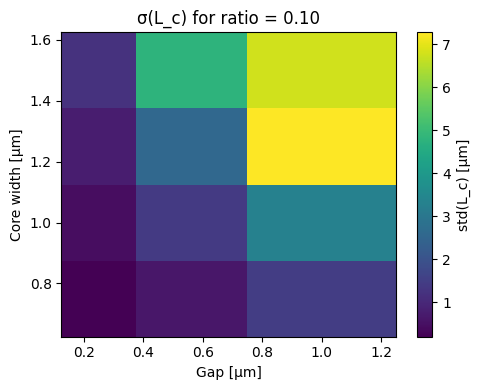

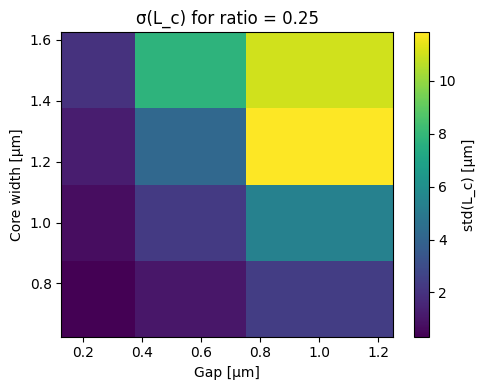

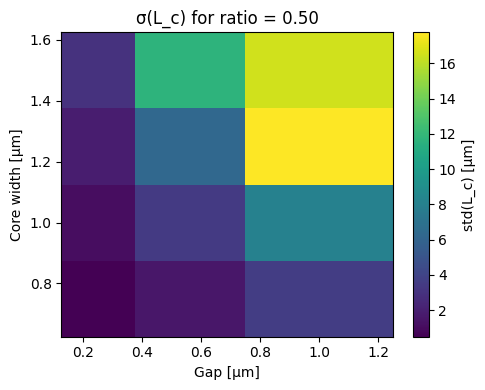

In [33]:
sigma_w = 0.025   # 10 nm
sigma_g = 0.025   # 20 nm

sigma_L = monte_carlo_sigma_L(ds, sigma_w=sigma_w, sigma_g=sigma_g,
                              n_samples=1000, seed=42)

# Heatmaps for each ratio
for r in sigma_L.coords["ratio"].values:
    s_map = sigma_L.sel(ratio=r)

    plt.figure(figsize=(5, 4))
    s_map.plot(
        x="gap",
        y="core_width",
        cbar_kwargs={"label": "std(L_c) [µm]"},
    )
    plt.title(f"σ(L_c) for ratio = {r:.2f}")
    plt.xlabel("Gap [µm]")
    plt.ylabel("Core width [µm]")
    plt.tight_layout()
    plt.show()

In [34]:
def monte_carlo_ratio_at_point(
    ds: xr.Dataset,
    core_width_nom: float,
    gap_nom: float,
    ratio_nom: float,
    sigma_w: float,
    sigma_g: float,
    n_samples: int = 1000,
    seed: int | None = None,
):
    """Monte Carlo prediction of splitting ratio variation for one design point.

    Uses linearization in ratio based on dL/dr from LUT.
    Returns dict with arrays and basic statistics.
    """
    rng = np.random.default_rng(seed)

    # Physical interaction length on chip: nominal target length
    L_phys = float(
        ds.coupling_length.sel(
            core_width=core_width_nom,
            gap=gap_nom,
            ratio=ratio_nom,
            method="nearest",
        ).values
    )

    # Draw random width/gap samples
    w_samples = core_width_nom + rng.normal(0.0, sigma_w, size=n_samples)
    g_samples = gap_nom + rng.normal(0.0, sigma_g, size=n_samples)

    # Clip to grid
    widths = ds.coords["core_width"].values
    gaps = ds.coords["gap"].values
    w_samples = np.clip(w_samples, widths[0], widths[-1])
    g_samples = np.clip(g_samples, gaps[0], gaps[-1])

    ratios = np.empty(n_samples, dtype=float)

    # Precompute dL/dr on the grid, then interpolate
    dL_dr = ds.coupling_length.differentiate("ratio")

    for i in range(n_samples):
        # Required length for nominal ratio at perturbed (w',g')
        L_req = ds.coupling_length.interp(
            core_width=w_samples[i],
            gap=g_samples[i],
            ratio=ratio_nom,
        )
        L_req = float(np.asarray(L_req).squeeze())

        # Local derivative dL/dr at perturbed (w',g', r_nom)
        dL_dr_loc = dL_dr.interp(
            core_width=w_samples[i],
            gap=g_samples[i],
            ratio=ratio_nom,
        )
        dL_dr_loc = float(np.asarray(dL_dr_loc).squeeze())

        # Avoid division by zero (if LUT is weird)
        if abs(dL_dr_loc) < 1e-12:
            ratios[i] = ratio_nom
            continue

        # Linearized actual ratio
        ratios[i] = ratio_nom + (L_phys - L_req) / dL_dr_loc

    # Basic stats
    r_mean = float(ratios.mean())
    r_std = float(ratios.std())
    r_p5 = float(np.percentile(ratios, 5))
    r_p95 = float(np.percentile(ratios, 95))

    return dict(
        ratios=ratios,
        r_mean=r_mean,
        r_std=r_std,
        r_p5=r_p5,
        r_p95=r_p95,
    )

mean ratio: 0.4520364084259277
std ratio: 0.047479467183461105
5–95% interval: 0.36167672828358655 0.5


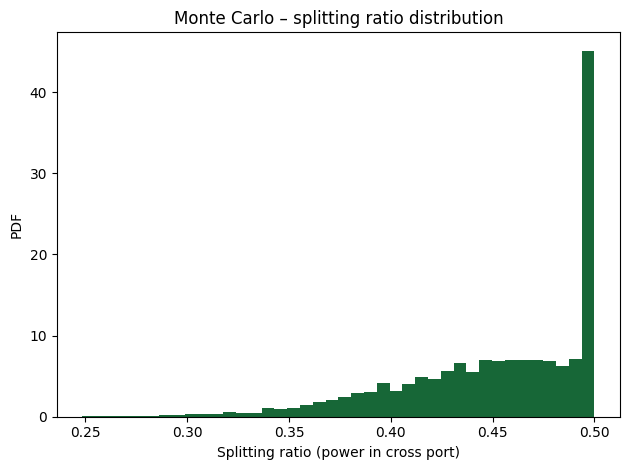

In [36]:
res = monte_carlo_ratio_at_point(
    ds,
    core_width_nom=0.75,
    gap_nom=0.25,
    ratio_nom=0.5,
    sigma_w=0.025,
    sigma_g=0.025,
    n_samples=5000,
    seed=1,
)

print("mean ratio:", res["r_mean"])
print("std ratio:", res["r_std"])
print("5–95% interval:", res["r_p5"], res["r_p95"])

plt.figure()
plt.hist(res["ratios"], bins=40, density=True)
plt.xlabel("Splitting ratio (power in cross port)")
plt.ylabel("PDF")
plt.title("Monte Carlo – splitting ratio distribution")
plt.tight_layout()
plt.show()

In [38]:
def sigma_ratio_grid(
    ds: xr.Dataset,
    sigma_w: float,
    sigma_g: float,
    n_samples: int = 1000,
    seed: int | None = None,
) -> xr.DataArray:
    """Compute std of splitting ratio for each (w, gap, ratio_nom) on the grid."""
    widths = ds.coords["core_width"].values
    gaps = ds.coords["gap"].values
    ratios_nom = ds.coords["ratio"].values

    sigma_ratio = np.empty(
        (len(widths), len(gaps), len(ratios_nom)),
        dtype=float,
    )

    for iw, w in enumerate(widths):
        for ig, g in enumerate(gaps):
            for ir, r0 in enumerate(ratios_nom):
                res = monte_carlo_ratio_at_point(
                    ds=ds,
                    core_width_nom=w,
                    gap_nom=g,
                    ratio_nom=r0,
                    sigma_w=sigma_w,
                    sigma_g=sigma_g,
                    n_samples=n_samples,
                    seed=seed,
                )
                sigma_ratio[iw, ig, ir] = res["r_std"]

    da = xr.DataArray(
        sigma_ratio,
        dims=("core_width", "gap", "ratio"),
        coords=dict(
            core_width=widths,
            gap=gaps,
            ratio=ratios_nom,
        ),
        name="sigma_ratio",
    )
    return da

sigma_r = sigma_ratio_grid(ds, sigma_w=0.025, sigma_g=0.025,
                           n_samples=2000, seed=1)

for r0 in sigma_r.coords["ratio"].values:
    plt.figure(figsize=(5, 4))
    sigma_r.sel(ratio=r0).plot(
        x="gap",
        y="core_width",
        cbar_kwargs={"label": "std(ratio) [abs]"},
    )
    plt.title(f"σ(ratio) for nominal ratio = {r0:.2f}")
    plt.xlabel("Gap [µm]")
    plt.ylabel("Core width [µm]")
    plt.tight_layout()
    plt.show()


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define which couplers you want to evaluate
selected_couplers = [
    {"core_width": 0.75, "gap": 0.25, "ratio_nom": 0.5},
    {"core_width": 1.00, "gap": 0.25, "ratio_nom": 0.5},
    {"core_width": 0.75, "gap": 0.25, "ratio_nom": 0.25},
    {"core_width": 1.00, "gap": 0.25, "ratio_nom": 0.25},
    {"core_width": 0.75, "gap": 0.25, "ratio_nom": 0.1},
    {"core_width": 1.00, "gap": 0.25, "ratio_nom": 0.1},

    # medium coupling
    {"core_width": 0.75, "gap": 0.50, "ratio_nom": 0.5},
    {"core_width": 1.00, "gap": 0.50, "ratio_nom": 0.5},

    # optional: lower ratios
    {"core_width": 0.75, "gap": 0.25, "ratio_nom": 0.25},
    {"core_width": 0.75, "gap": 0.25, "ratio_nom": 0.10},
]

sigma_w = 0.01   # 10 nm
sigma_g = 0.02   # 20 nm
n_samples = 5000

rows = []

for spec in selected_couplers:
    w = spec["core_width"]
    g = spec["gap"]
    r0 = spec["ratio_nom"]

    res = monte_carlo_ratio_at_point(
        ds=ds,
        core_width_nom=w,
        gap_nom=g,
        ratio_nom=r0,
        sigma_w=sigma_w,
        sigma_g=sigma_g,
        n_samples=n_samples,
        seed=1,  # fix seed for reproducibility
    )

    rows.append(
        dict(
            core_width=w,
            gap=g,
            ratio_nom=r0,
            ratio_mean=res["r_mean"],
            ratio_std=res["r_std"],
            ratio_p5=res["r_p5"],
            ratio_p95=res["r_p95"],
        )
    )

    # Optional: quick histogram for each coupler
    plt.figure()
    plt.hist(res["ratios"], bins=40, density=True)
    plt.xlabel("Splitting ratio (power in cross port)")
    plt.ylabel("PDF")
    plt.title(f"MC ratio dist – w={w:.2f} µm, g={g:.2f} µm, r0={r0:.2f}")
    plt.tight_layout()
    plt.show()

df_results = pd.DataFrame(rows)
print(df_results)

In [39]:
def monte_carlo_from_df(
    ds: xr.Dataset,
    df_input: pd.DataFrame,
    sigma_w: float,
    sigma_g: float,
    n_samples: int = 2000,
    seed: int | None = None,
    plot_histograms: bool = False,
):
    """Run Monte Carlo ratio analysis for all couplers listed in df_input.

    Required columns:
        core_width, gap, ratio_nom

    Returns:
        DataFrame with:
        core_width, gap, ratio_nom, ratio_mean, ratio_std, ratio_p5, ratio_p95
    """
    rows = []

    for idx, row in df_input.iterrows():
        w = float(row["core_width"])
        g = float(row["gap"])
        r0 = float(row["ratio_nom"])

        res = monte_carlo_ratio_at_point(
            ds=ds,
            core_width_nom=w,
            gap_nom=g,
            ratio_nom=r0,
            sigma_w=sigma_w,
            sigma_g=sigma_g,
            n_samples=n_samples,
            seed=seed,
        )

        rows.append(
            dict(
                core_width=w,
                gap=g,
                ratio_nom=r0,
                ratio_mean=res["r_mean"],
                ratio_std=res["r_std"],
                ratio_p5=res["r_p5"],
                ratio_p95=res["r_p95"],
            )
        )

        # Optional histogram plotting
        if plot_histograms:
            plt.figure()
            plt.hist(res["ratios"], bins=40, density=True)
            plt.xlabel("Splitting ratio")
            plt.ylabel("PDF")
            plt.title(f"MC ratio dist – w={w:.2f}, g={g:.2f}, r0={r0:.2f}")
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(rows)

In [45]:
df_candidates = pd.DataFrame([
    {"core_width": 0.75, "gap": 0.25, "ratio_nom": 0.5},
    {"core_width": 1.00, "gap": 0.25, "ratio_nom": 0.5},
    {"core_width": 1.25, "gap": 0.25, "ratio_nom": 0.5},
    {"core_width": 1.50, "gap": 0.25, "ratio_nom": 0.5},
    {"core_width": 0.75, "gap": 0.50, "ratio_nom": 0.5},
    {"core_width": 1.00, "gap": 0.50, "ratio_nom": 0.5},
    {"core_width": 1.25, "gap": 0.50, "ratio_nom": 0.5},
    {"core_width": 1.50, "gap": 0.50, "ratio_nom": 0.5},
    {"core_width": 0.75, "gap": 0.25, "ratio_nom": 0.25},
    {"core_width": 1.00, "gap": 0.25, "ratio_nom": 0.25},
    {"core_width": 1.25, "gap": 0.25, "ratio_nom": 0.25},
    {"core_width": 1.50, "gap": 0.25, "ratio_nom": 0.25},
    {"core_width": 0.75, "gap": 0.50, "ratio_nom": 0.25},
    {"core_width": 1.00, "gap": 0.50, "ratio_nom": 0.25},
    {"core_width": 1.25, "gap": 0.50, "ratio_nom": 0.25},
    {"core_width": 1.50, "gap": 0.50, "ratio_nom": 0.25},
    {"core_width": 0.75, "gap": 0.25, "ratio_nom": 0.1},
    {"core_width": 1.00, "gap": 0.25, "ratio_nom": 0.1},
    {"core_width": 1.25, "gap": 0.25, "ratio_nom": 0.1},
    {"core_width": 1.50, "gap": 0.25, "ratio_nom": 0.1},
    {"core_width": 0.75, "gap": 0.50, "ratio_nom": 0.1},
    {"core_width": 1.00, "gap": 0.50, "ratio_nom": 0.1},
    {"core_width": 1.25, "gap": 0.50, "ratio_nom": 0.1},
    {"core_width": 1.50, "gap": 0.50, "ratio_nom": 0.1},
])

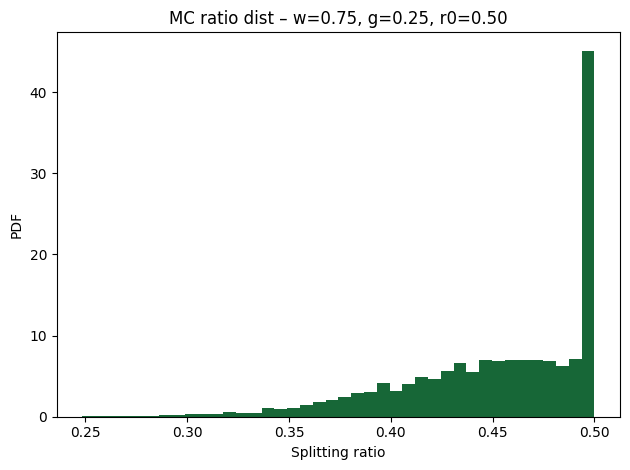

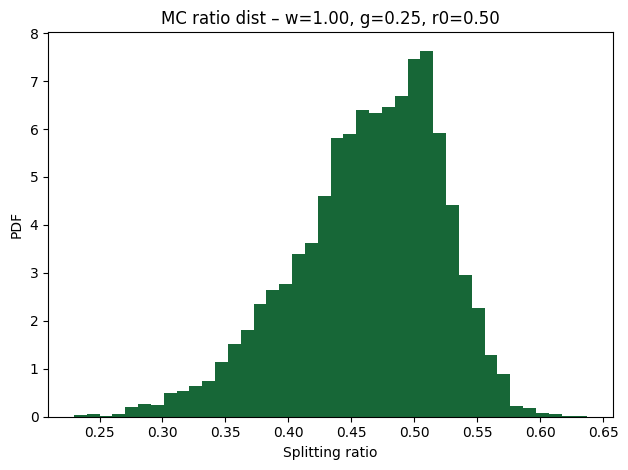

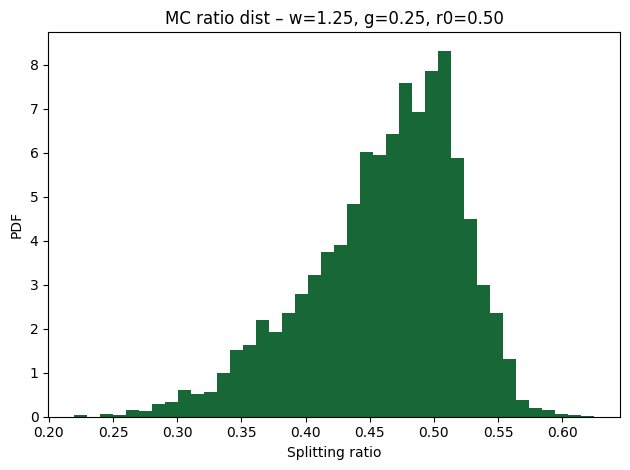

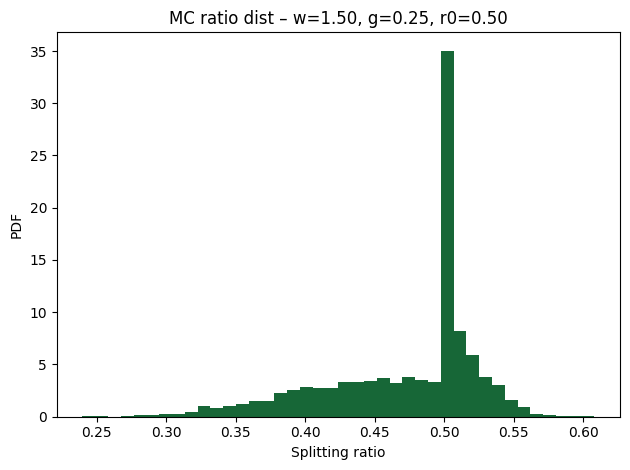

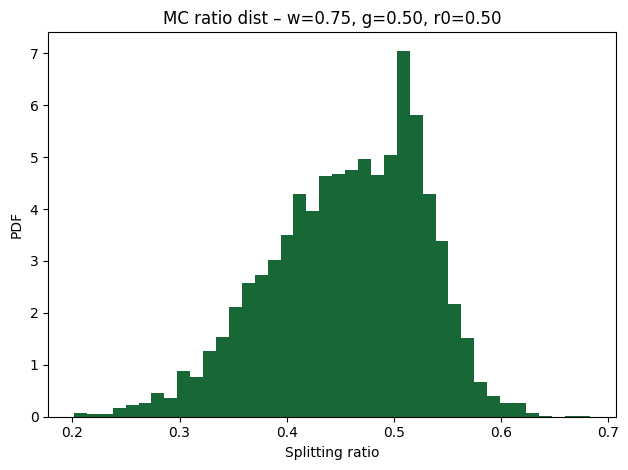

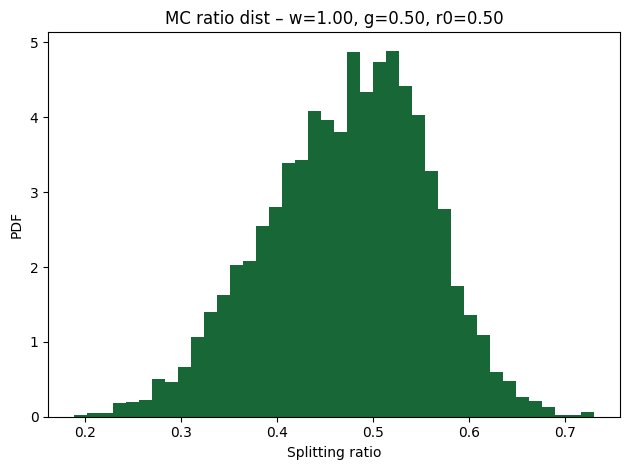

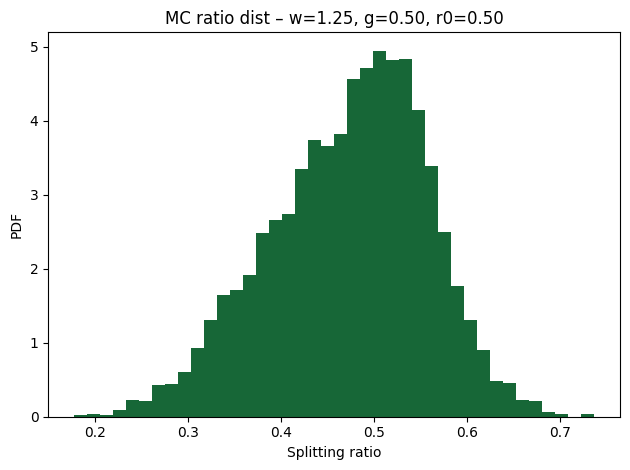

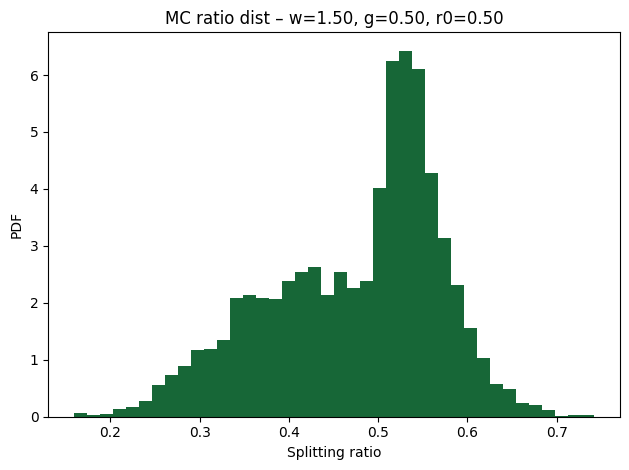

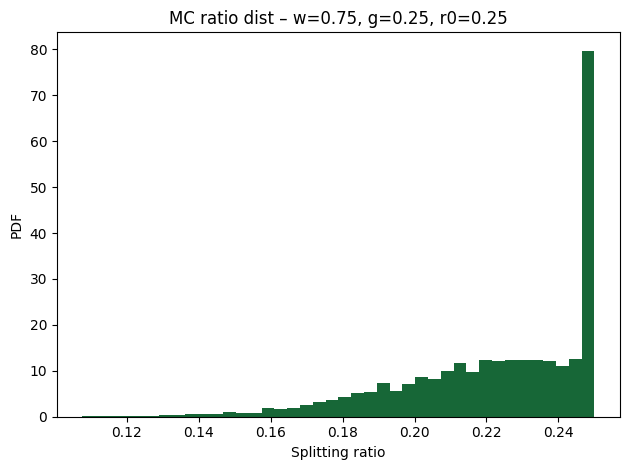

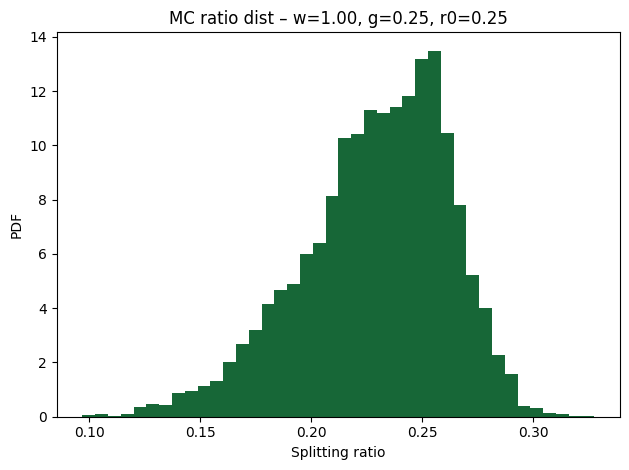

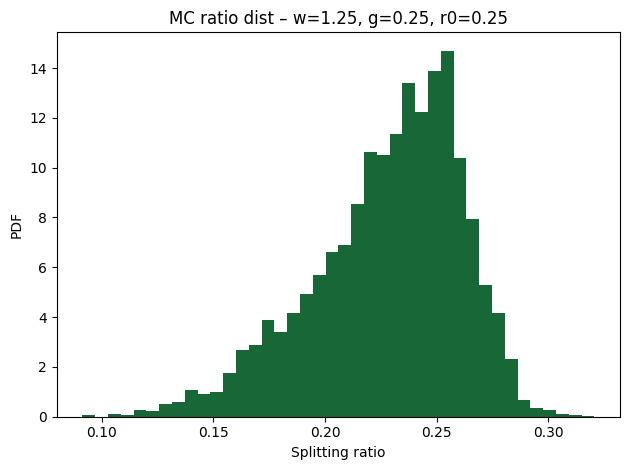

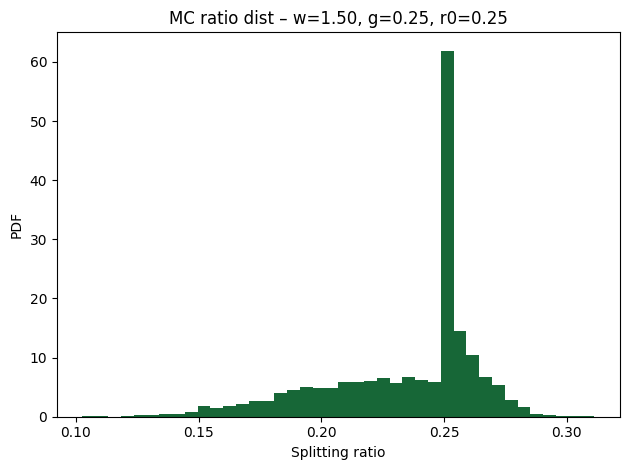

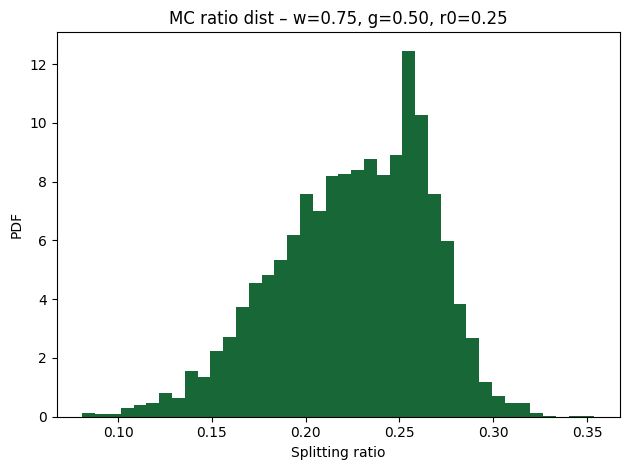

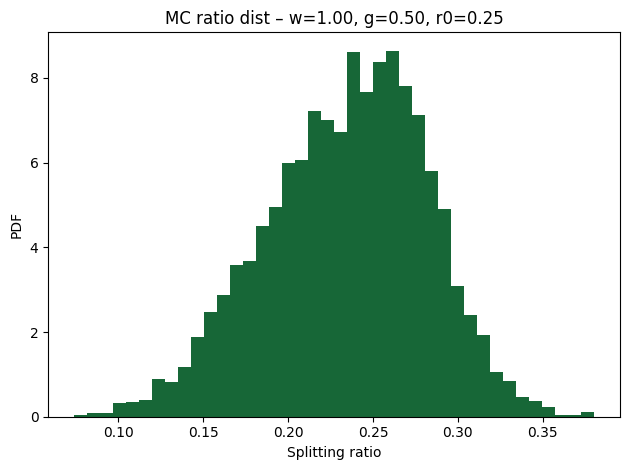

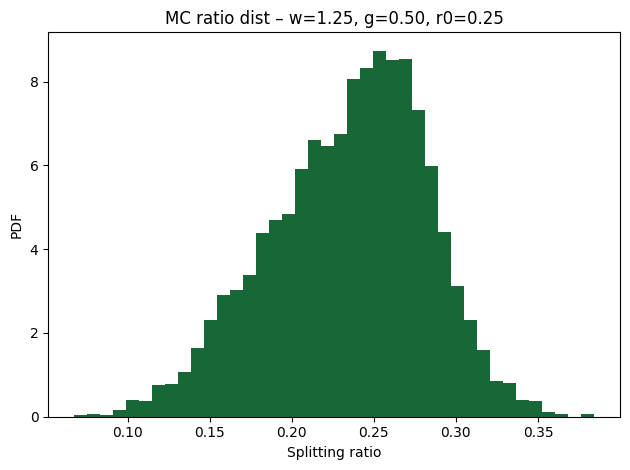

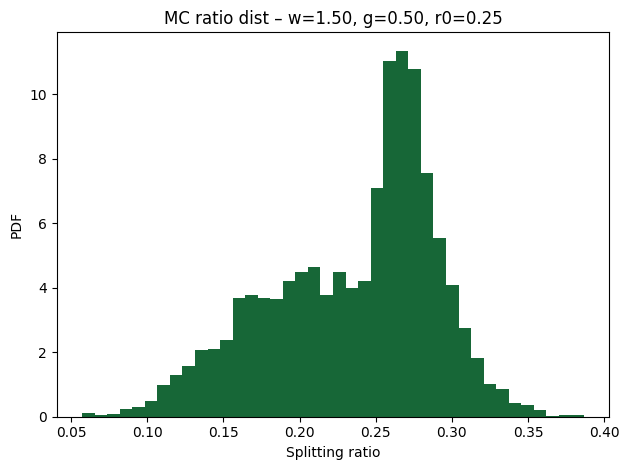

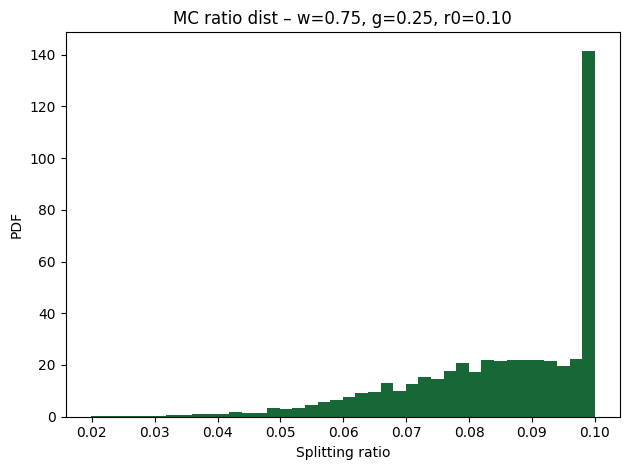

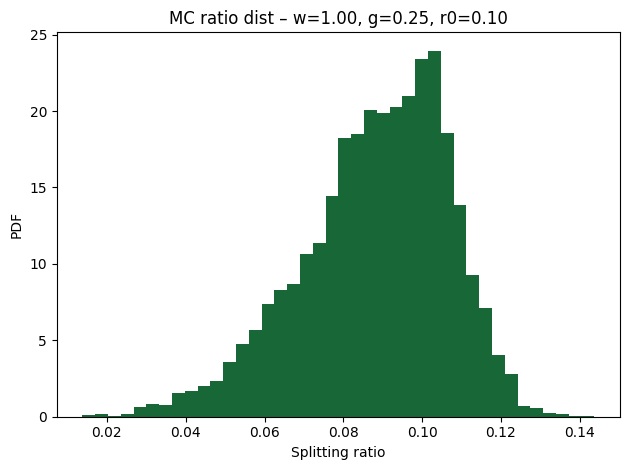

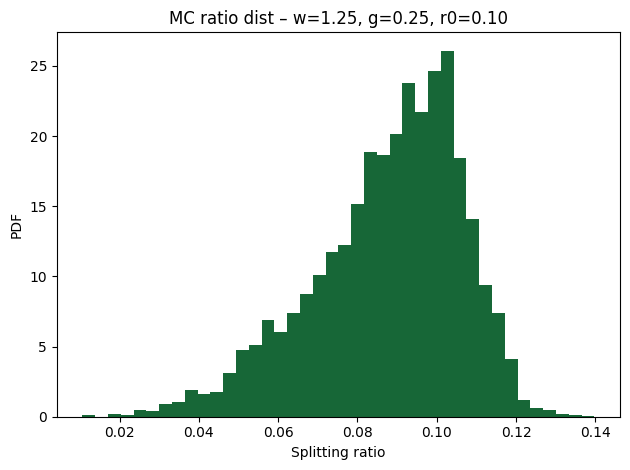

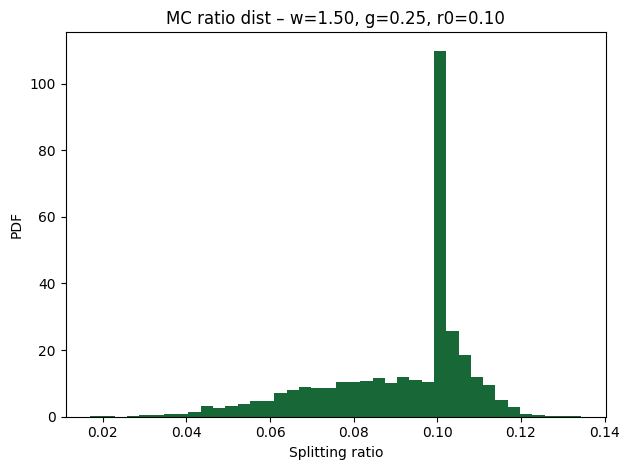

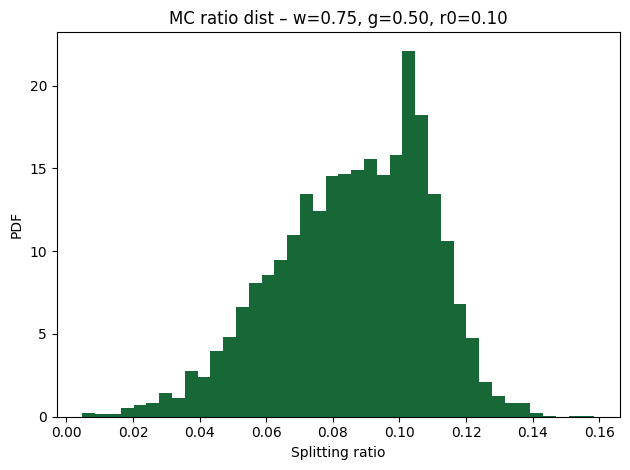

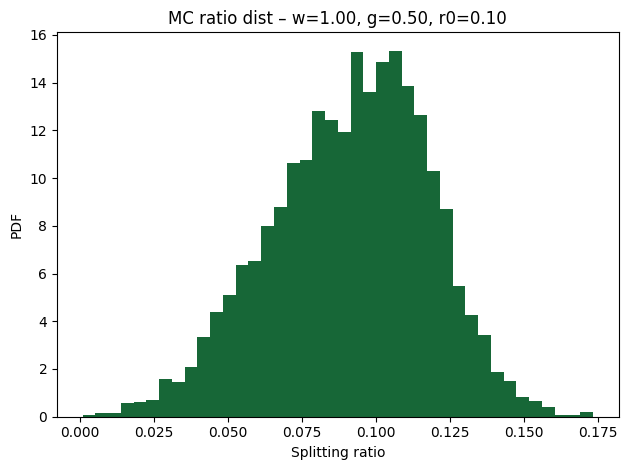

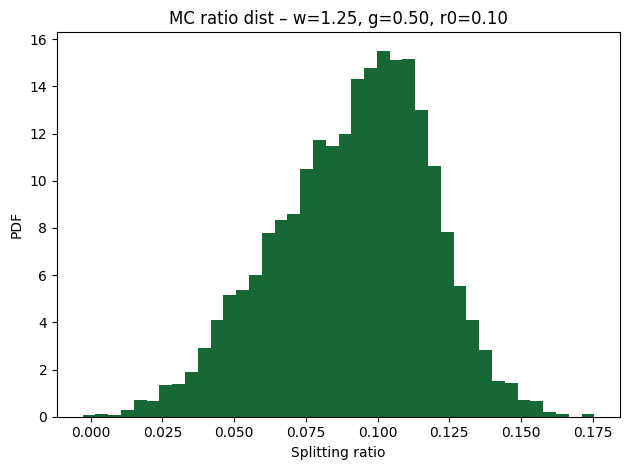

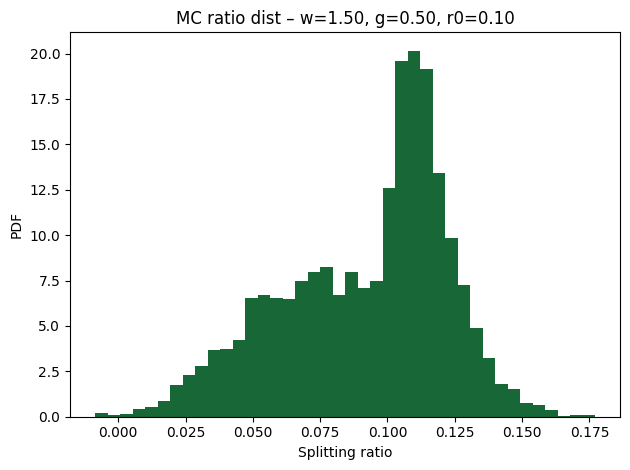

In [46]:

df_results = monte_carlo_from_df(
    ds=ds,
    df_input=df_candidates,
    sigma_w=tol_g,    # xx nm
    sigma_g=tol_w,    # xx nm
    n_samples=5000,
    seed=1,
    plot_histograms=True,
)

In [47]:
print(df_results)

    core_width   gap  ratio_nom  ratio_mean  ratio_std  ratio_p5  ratio_p95
0         0.75  0.25       0.50    0.452036   0.047479  0.361677   0.500000
1         1.00  0.25       0.50    0.463029   0.058634  0.356267   0.546065
2         1.25  0.25       0.50    0.461409   0.059041  0.349297   0.541819
3         1.50  0.25       0.50    0.471542   0.055501  0.357868   0.536168
4         0.75  0.50       0.50    0.456729   0.071351  0.331352   0.557759
5         1.00  0.50       0.50    0.472750   0.083705  0.327803   0.599635
6         1.25  0.50       0.50    0.473216   0.084689  0.323417   0.598878
7         1.50  0.50       0.50    0.475435   0.095930  0.298132   0.602757
8         0.75  0.25       0.25    0.222859   0.026867  0.171727   0.250000
9         1.00  0.25       0.25    0.229079   0.033179  0.168666   0.276067
10        1.25  0.25       0.25    0.228163   0.033409  0.164722   0.273664
11        1.50  0.25       0.25    0.233896   0.031406  0.169572   0.270466
12        0.